# Project: SkimLit

## Comfirming access to GPU

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0ea7ff3b-e7d9-bedb-2fd9-382c44494cd2)


## Get the data

from the paper we are trying to replicate find the data set from the github: https://github.com/Franck-Dernoncourt/pubmed-rct


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 41.89 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the Pubmed_rct 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k datasets with numbers replaced with at sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocessing data

> now we have seen that our data needs to be preprocessed to get it into the format that our tensor can accept and we can continue to train our model for our solution.



In [6]:
# Create a function to read a line of a document
def get_lines(filename):
  """
  Reads filename (a text filename ) and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of string with one string per line from the target filename.
  """

  with open(filename , 'r') as f:
    return f.readlines()


In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir + 'train.txt') # read the lines with the training file
train_lines[50:100]

['RESULTS\tAltogether , @ patients were randomised to either UrgoClean ( test group ; n = @ ) or Aquacel ( control group ; n = @ ) dressings .\n',
 'RESULTS\tRegarding the wound healing process predictive factors ( wound area , duration , ABPI value , recurrence ) , at baseline , the two groups were well balanced , for both wound and patient characteristics .\n',
 'RESULTS\tCompression therapy was administered to both groups and after a median @-day treatment period , the percentage of relative reduction of the wound surface area was very similar ( -@ % vs -@ % in the UrgoClean and control groups , respectively ) .\n',
 'RESULTS\tWhen considering the secondary criteria at week @ , the relative reduction of sloughy tissue was significantly higher in the UrgoClean group than in the control group ( -@ % vs -@,@ % ; p = @ ) .\n',
 'RESULTS\tThe percentage of debrided wounds was also significantly higher in the test group ( @ % vs @ % ; p = @ ) .\n',
 "CONCLUSIONS\tThis ` EARTH ' RCT confir

In [8]:
len(train_lines)

210040

Let's change our file into the required format.

the format of the data

```

[{
  'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

  ```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it

%%time

train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # dev meaning the validation data
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 676 ms, sys: 134 ms, total: 809 ms
Wall time: 930 ms


In [11]:
# check the first samples to see if we have got our data in the format we want it.
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that we have the data in a dictionary , how about we visualize it more using panda framework

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

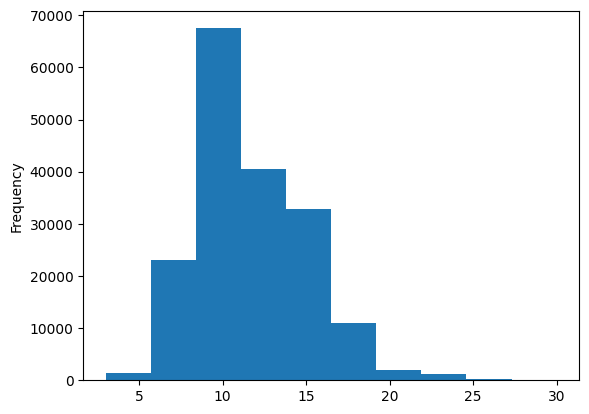

In [14]:
# Let's check the lenght of different lines
train_df.total_lines.plot.hist()

### Get list of setences

In [15]:
# Convert abstract textlines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numberic labels (ML models require numerics labels)

In [17]:
#One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# check what one hot encoder look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract Labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# ckeck what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get the classes name and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

we will be trying a alot of different models and seeing which will work the best.

baseline (TF-IDF Multinomial Naive Bayes Classifier )

## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


# Create a pipepline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [22]:
# Make some Predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
### Download helper function script and use it to compare predictions across different metrics
!wget https://raw.githubusercontent.com/yohannesME/machine-learning-tensorflow-archieve/main/helper_functions.py

from helper_functions import *


--2024-06-18 17:06:29--  https://raw.githubusercontent.com/yohannesME/machine-learning-tensorflow-archieve/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11310 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  11.04K  --.-KB/s    in 0.001s  

2024-06-18 17:06:29 (17.0 MB/s) - ‘helper_functions.py’ saved [11310/11310]



In [24]:
baseline_results = calculate_results(val_labels_encoded,  baseline_preds)

In [25]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for deep sequence models

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [27]:
# How long is each sentence in average ?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

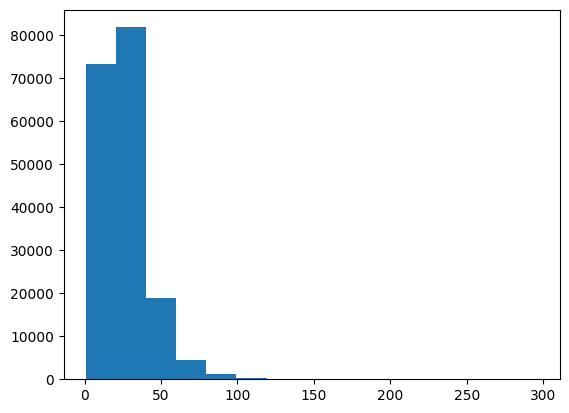

In [28]:
# What's the distribution look like?

plt.hist(sent_lens, bins=15);


In [29]:
# How long of a sentence length covers 95% of examples?

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Maximum Sequence length in training set
max(sent_lens)

296

## Creating a text vectorizer

In [31]:
from tensorflow.keras.layers import TextVectorization

max_tokens = 68000 # taken from the original paper
max_length = output_seq_len

# Use the default textVectorizer variables
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                 output_mode='int',
                                 output_sequence_length=max_length)

In [32]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)

print(f"""
  text: {target_sentence} /n
  length of sentence: {len(target_sentence.split())} /n
  vectorized text: {text_vectorizer([target_sentence])}

""")


  text: lavender aromatherapy has improved sleep in a variety of clinical settings , but the effect has not been tested in the intermediate care unit . /n
  length of sentence: 25 /n
  vectorized text: [[14821 13507   139   170   354     5     8  3368     4    47  1094    72
      2    70   139    31   167   567     5     2  2122    77   835     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]




In [34]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: { len(rct_20k_text_vocab)}")
print(f"MOst common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"MOst Uncommon words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
MOst common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
MOst Uncommon words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Creating Custom Embedding Layer

In [36]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero=True, # use masking to handle variable efficient computing saving space
                             input_length=max_length,
                             name='token_embed')

In [37]:
# show example embedding
print(f"Sentence before vectorization: \n { target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding): \n {vectorized_sentence}')
embedded_sentences = token_embed(vectorized_sentence)
print(f"sentence after embedding: \n {embedded_sentences}")
print(f"the shape: {embedded_sentences.shape}")

Sentence before vectorization: 
 lavender aromatherapy has improved sleep in a variety of clinical settings , but the effect has not been tested in the intermediate care unit .
Sentence after vectorization (before embedding): 
 [[14821 13507   139   170   354     5     8  3368     4    47  1094    72
      2    70   139    31   167   567     5     2  2122    77   835     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
sentence after embedding: 
 [[[-0.00078536 -0.02151852 -0.00641115 ... -0.00624564 -0.02795504
   -0.04652473]
  [ 0.04754441 -0.04740455  0.03224304 ...  0.03493899  0.0393533
   -0.03676937]
  [-0.04726887 -0.04806795 -0.00556401 ...  0.01219445 -0.01168113
    0.02923441]
  ...
  [ 0.04134429  0.0165231  -0.02861233 ...  0.04816606 -0.02558588
    0.02398128]
  [ 0.04134429  0.0165231  -0.02861233 ...  0.04816606 -0.0255858

## Creating datasets (making sure that our data loads as fast as possible)

In [38]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
# Take the TensorFlow Dataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D Model

In [40]:

from tensorflow.keras import layers

#Create our model

# create and input
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # pass it to the text_vectorizer
token_embedding = token_embed(text_vectors) # then we embed them
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation='relu',
                  padding='valid'
                  )(token_embedding) # use Conv1D model
x = layers.GlobalAveragePooling1D()(x) # we must pool the layers so that we can combine them
x = layers.Dense(64, activation='relu')(x) # add a dense layer for more hidden layer
outputs = layers.Dense(num_classes, activation='softmax')(x) # activation softmax as multiclass classification and 5 output classe

model_1 = tf.keras.Model(inputs, outputs, name='model_1_Conv1D') # create the model


In [41]:
# compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [42]:
SAVE_DIR = 'model_logs'

# fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(.1 * len(valid_dataset)),
                              callbacks=[ create_tensorboard_callback(SAVE_DIR, 'model_1_Conv1D')])

Saving TensorBoard log files to: model_logs/model_1_Conv1D/20240618-170701
Epoch 1/3
562/562 [==============================] - 20s 30ms/step - loss: 0.9095 - accuracy: 0.6309 - val_loss: 0.6942 - val_accuracy: 0.7207
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.6673 - accuracy: 0.7419 - val_loss: 0.6484 - val_accuracy: 0.7530
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6215 - accuracy: 0.7630 - val_loss: 0.5867 - val_accuracy: 0.7796


In [43]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.5986 - accuracy: 0.7737


[0.5986128449440002, 0.7737323045730591]

In [44]:
# Make Predictions (our model predicts predictions probabilities of each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.55847651e-01, 1.03507020e-01, 4.30218726e-02, 3.88923615e-01,
         8.69981851e-03],
        [4.41335231e-01, 1.78024605e-01, 7.45724421e-03, 3.70457649e-01,
         2.72530736e-03],
        [2.14075714e-01, 1.54997017e-02, 1.26506295e-02, 7.57592916e-01,
         1.80945339e-04],
        ...,
        [2.87027051e-05, 3.35753057e-03, 1.11741815e-02, 6.80788798e-06,
         9.85432804e-01],
        [5.97842149e-02, 4.48883921e-01, 1.81292847e-01, 7.88779557e-02,
         2.31161028e-01],
        [1.48012936e-01, 6.16887033e-01, 4.44776118e-02, 5.58426231e-02,
         1.34779841e-01]], dtype=float32),
 (30212, 5))

In [45]:
# Convert red probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)

In [47]:
model_1_results

{'accuracy': 77.3732291804581,
 'precision': 0.7766980550678799,
 'recall': 0.7737322918045809,
 'f1': 0.7724213515556596}

In [48]:
compare_baseline_to_new_results(baseline_results, model_1_results)

Baseline accuracy: 72.18, New accuracy: 77.37, Difference: 5.19
Baseline precision: 0.72, New precision: 0.78, Difference: 0.06
Baseline recall: 0.72, New recall: 0.77, Difference: 0.05
Baseline f1: 0.70, New f1: 0.77, Difference: 0.07


## Model 2: TensorFlow Hub Pretrained Feature Extractor

> the paper originally used GLOVE Encoding but it was outdated so we now are using a universal sentence encoder that is the latest encoder out there.

In [49]:
# Create a keras layer using the use pretrained layer from tensorflow hub
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [50]:
## Building and fitting an NLP feature extraction model using pretrained embedding

In [51]:
# # Create a model using the Sequential API

# model_2 = tf.keras.Sequential([
#     sentence_encoder_layer,
#     layers.Dense(64, activation='relu'),
#     layers.Dense(5, activation='softmax')
# ])


# Create a model using the Functional API
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = sentence_encoder_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE_feature_extraction')


# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])




In [52]:
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(.1 * len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_2_Pretrained_Feature_Extraction')])

Saving TensorBoard log files to: model_logs/model_2_Pretrained_Feature_Extraction/20240618-170801
Epoch 1/3
562/562 [==============================] - 13s 12ms/step - loss: 0.9176 - accuracy: 0.6474 - val_loss: 0.7982 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7691 - accuracy: 0.7012 - val_loss: 0.7556 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 6s 12ms/step - loss: 0.7521 - accuracy: 0.7131 - val_loss: 0.7395 - val_accuracy: 0.7104


In [53]:
model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [54]:
# Evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7412 - accuracy: 0.7137


[0.7412354946136475, 0.7136568427085876]

In [55]:
model_2_pred_probs = model_2.predict(valid_dataset)

945/945 [==============================] - 9s 9ms/step


In [56]:
model_2_pred_probs

array([[4.1669327e-01, 3.5102171e-01, 3.3595760e-03, 2.1802136e-01,
        1.0904044e-02],
       [3.3745208e-01, 5.3359056e-01, 4.3836888e-03, 1.2156230e-01,
        3.0113743e-03],
       [2.1550402e-01, 1.6100614e-01, 2.1651965e-02, 5.6283575e-01,
        3.9002158e-02],
       ...,
       [1.8981454e-03, 5.3373356e-03, 5.2934118e-02, 8.3548599e-04,
        9.3899494e-01],
       [4.3442668e-03, 4.8554894e-02, 2.1788873e-01, 1.3379618e-03,
        7.2787410e-01],
       [1.7601883e-01, 2.0368771e-01, 5.5752575e-01, 5.3881630e-03,
        5.7379540e-02]], dtype=float32)

In [57]:
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [58]:
model_2_results = calculate_results(val_labels_encoded, model_2_pred)

In [59]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 72.18, New accuracy: 71.37, Difference: -0.82
Baseline precision: 0.72, New precision: 0.71, Difference: -0.00
Baseline recall: 0.72, New recall: 0.71, Difference: -0.01
Baseline f1: 0.70, New f1: 0.71, Difference: 0.01


## Model 3: Conv1D with character embedding

> the paper used the combination of character and token level embedding so let's explore character embedding.

### Create a charater-level tokenizer

In [60]:
# Make a function that split sentences into characters
def split_char(text):
  return ' '.join(list(text))


# Text splitting non-character-level sequence into characters
split_char('charactersturned in to spaces characters so that we can do vectorization in character level')

'c h a r a c t e r s t u r n e d   i n   t o   s p a c e s   c h a r a c t e r s   s o   t h a t   w e   c a n   d o   v e c t o r i z a t i o n   i n   c h a r a c t e r   l e v e l'

In [61]:
# Split the sequence-level data split into character level data splits
train_chars = list(map(split_char, train_sentences))
val_chars = list(map(split_char, val_sentences))
test_chars = list(map(split_char, test_sentences))


train_chars[:4]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
# what's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

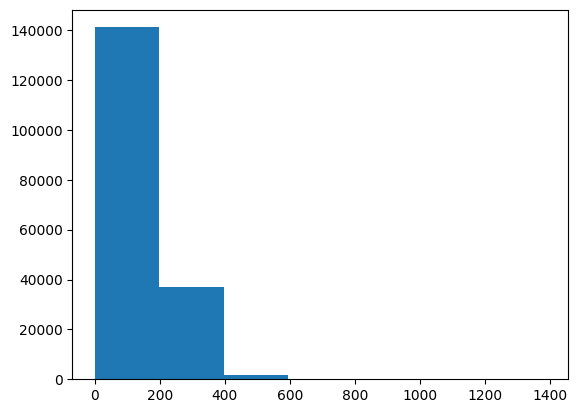

In [63]:
# Check the distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [64]:
# Find what character length covers 95% of Sequences
output_seq_char_len  = int (np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [66]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and [UNK] OR OOV
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [67]:
# Adapt vectorizer to the training characters
char_vectorizer.adapt(train_chars)

In [68]:
# check character voca stats
char_vocab = char_vectorizer.get_vocabulary()

print(f'Number of different in character vocab: {len(char_vocab)}')
print(f'5 most common char: {char_vocab[:5]}')
print(f'5 least most common char: {char_vocab[-5:]}')


Number of different in character vocab: 28
5 most common char: ['', '[UNK]', 'e', 't', 'i']
5 least most common char: ['k', 'x', 'z', 'q', 'j']


In [69]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'charified text: \n {random_train_chars}')
print(f'length of random train_cahra: {len(random_train_chars)}')
vectorized_chars = char_vectorizer([random_train_chars])

print(f'{vectorized_chars} and the len\n {len(vectorized_chars[0])}')

charified text: 
 t h e   c h a r a c t e r i s t i c s   o f   t h e   @   g r o u p s   w e r e   s i m i l a r   .
length of random train_cahra: 99
[[ 3 13  2 11 13  5  8  5 11  3  2  8  4  9  3  4 11  9  7 17  3 13  2 18
   8  7 16 14  9 20  2  8  2  9  4 15  4 12  5  8  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0 

## Creating a Character-level embedding

In [70]:
# Create a character level embeding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name='char_embed')

In [71]:
# show example embedding
print(f"Sentence before vectorization: \n { random_train_chars}")
char_vectorized = char_vectorizer([random_train_chars])
print(f'Sentence after vectorization (before embedding): \n {char_vectorized}')
embedded_char = char_embed(char_vectorized)
print(f"sentence after embedding: \n {embedded_char}")
print(f"the shape: {embedded_char.shape}")

Sentence before vectorization: 
 t h e   c h a r a c t e r i s t i c s   o f   t h e   @   g r o u p s   w e r e   s i m i l a r   .
Sentence after vectorization (before embedding): 
 [[ 3 13  2 11 13  5  8  5 11  3  2  8  4  9  3  4 11  9  7 17  3 13  2 18
   8  7 16 14  9 20  2  8  2  9  4 15  4 12  5  8  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

### Building Conv1D model to fit on a character embedding

In [72]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,
                  kernel_size=5,
                  padding='same',
                  activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_Conv1D_character_embedding')



# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [73]:
model_3.summary()

Model: "model_3_Conv1D_character_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (No

In [74]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [75]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(.1 * len(val_char_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,  'model_3_Conv1D_character_embedding')])

Saving TensorBoard log files to: model_logs/model_3_Conv1D_character_embedding/20240618-170924
Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 0.4395 - accuracy: 0.4467 - val_loss: 0.3678 - val_accuracy: 0.5718
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 0.3482 - accuracy: 0.5884 - val_loss: 0.3284 - val_accuracy: 0.6177
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.3240 - accuracy: 0.6271 - val_loss: 0.3079 - val_accuracy: 0.6572


In [76]:
# Make Prediction with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)

945/945 [==============================] - 3s 3ms/step


In [77]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 72.18, New accuracy: 65.22, Difference: -6.96
Baseline precision: 0.72, New precision: 0.64, Difference: -0.08
Baseline recall: 0.72, New recall: 0.65, Difference: -0.07
Baseline f1: 0.70, New f1: 0.63, Difference: -0.06


## Model 4: Combine pretrained token embedding + characters embedding (hybrid embedding layer)

In [78]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = sentence_encoder_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [79]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978 

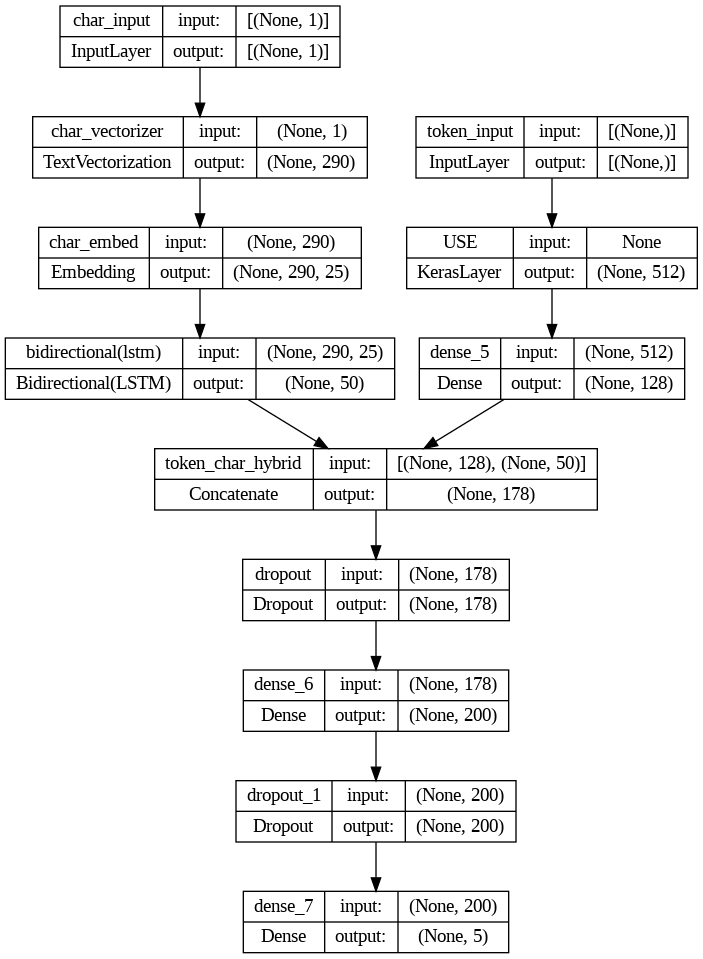

In [80]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [81]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and characters into data using tf.data

In [82]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [83]:
# check our dataset both
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [84]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,  "model_4_hybrid_char_token_embedding")])

Saving TensorBoard log files to: model_logs/model_4_hybrid_char_token_embedding/20240618-170951
Epoch 1/3
562/562 [==============================] - 43s 57ms/step - loss: 0.9632 - accuracy: 0.6171 - val_loss: 0.7704 - val_accuracy: 0.7058
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.7838 - accuracy: 0.6950 - val_loss: 0.7071 - val_accuracy: 0.7340
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7691 - accuracy: 0.7041 - val_loss: 0.6870 - val_accuracy: 0.7374


In [85]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)


945/945 [==============================] - 24s 26ms/step - loss: 0.6916 - accuracy: 0.7366


[0.6915618181228638, 0.7366278171539307]

In [86]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[4.7952253e-01, 2.8919199e-01, 4.5038681e-03, 2.2205813e-01,
        4.7235205e-03],
       [2.9915047e-01, 5.0827211e-01, 4.0486748e-03, 1.8669987e-01,
        1.8288373e-03],
       [2.8791589e-01, 1.9116506e-01, 5.0338358e-02, 4.3306282e-01,
        3.7517905e-02],
       ...,
       [6.6540233e-04, 8.8241398e-03, 6.0014278e-02, 2.5002597e-04,
        9.3024611e-01],
       [7.0855664e-03, 5.6427442e-02, 2.4221607e-01, 3.1865442e-03,
        6.9108438e-01],
       [2.6955688e-01, 4.8195750e-01, 1.6694359e-01, 2.4840366e-02,
        5.6701668e-02]], dtype=float32)

In [87]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [88]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.66278300013239,
 'precision': 0.7365693696854907,
 'recall': 0.7366278300013239,
 'f1': 0.7335091381101392}

## Model 5: Transfer Learning with pretrained token embedding + character embedding + positional embedding


In [89]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create a positional embeddings

In [90]:
# How many different line numbers are there
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

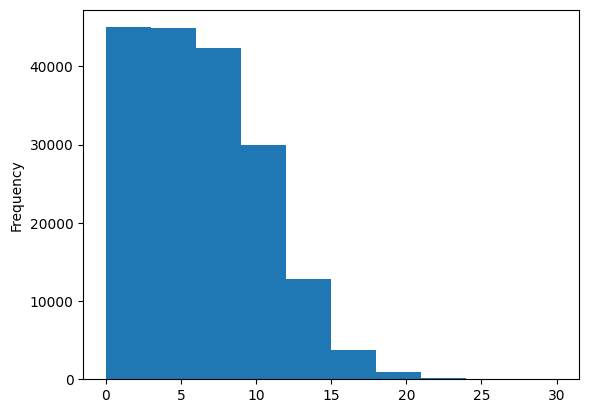

In [91]:
# Check the distribution of line number column
train_df.line_number.plot.hist()

In [92]:
# 98% Percent of our data has a line that is 15 in size.
np.percentile(train_df['line_number'], 98)

15.0

In [93]:
# Use TensorFlow to create one hot encoded tensors of the 'line number colum'
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [94]:
# Encode the total lines feature
# How many different number of lines are there
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

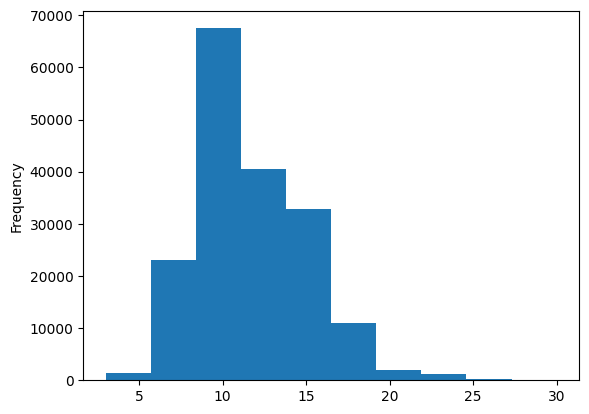

In [95]:
train_df.total_lines.plot.hist()

In [96]:
# In percentile
np.percentile(train_df['total_lines'], 98)

20.0

In [97]:
# Use TensorFlow to create one hot encoded tensors of the 'line number colum'
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. create a token-level model
2. create a character-level model
3. create a model for the 'line_number' features
4. create a model for the 'total_lines' features
5. combine the outputs for 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Cancatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and output of 7 into a tf.keras.Model

In [98]:
from tensorflow.keras import layers

# !. Token Input
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2 . Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_ltsm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_ltsm)


# 3. the line_number Model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32,  name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. the Total Lines Model
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embedding into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])

#pass it through the dropout layer
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(.5)(z)

# 6. Combine the positional embedding with combined token and char embedding
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_embedding_model')

In [99]:
# Get the summary
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   

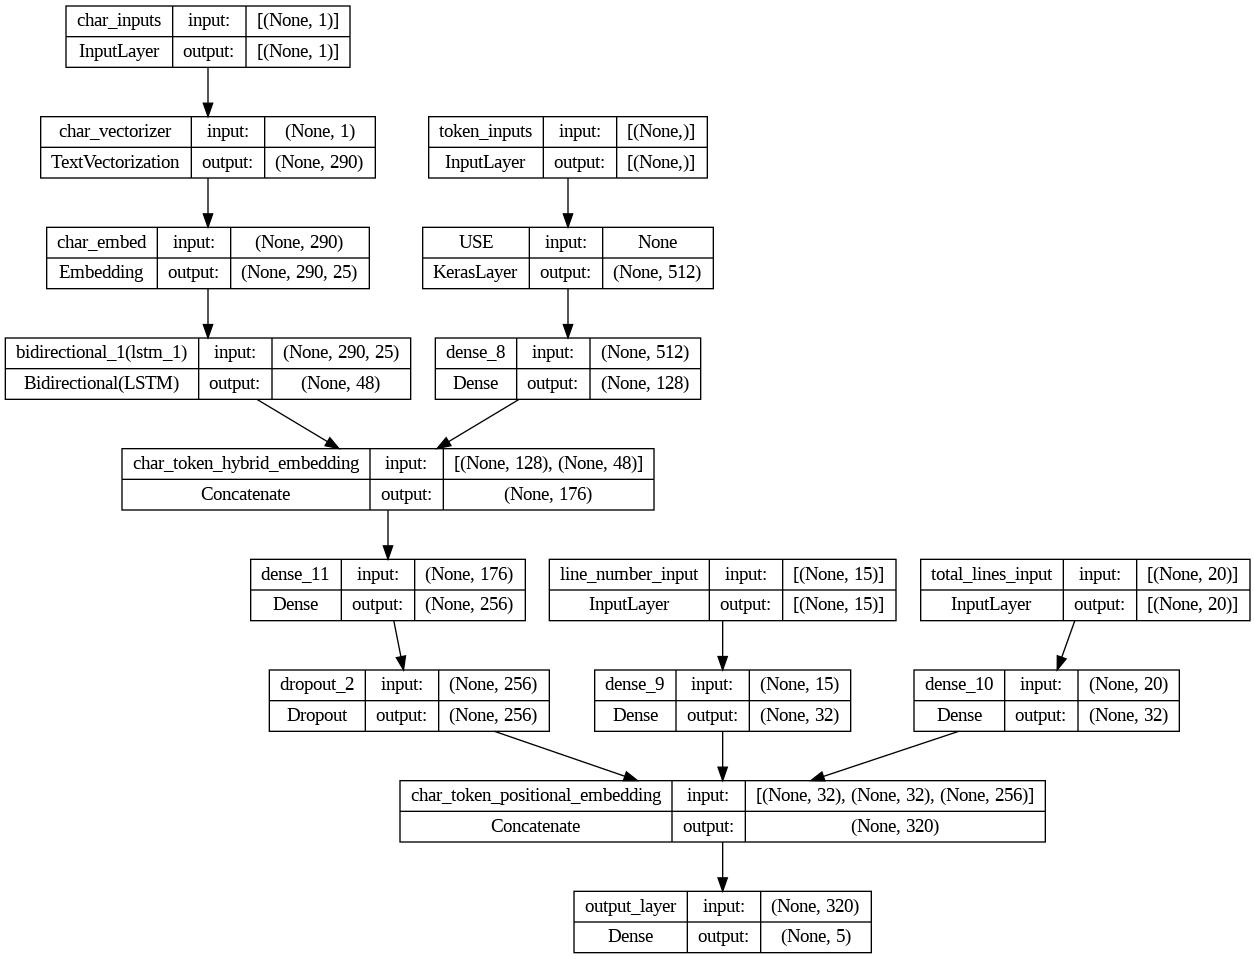

In [100]:
from keras.utils import plot_model

plot_model(model_5, show_shapes=True)

This time, we're going to introduce a new parameter to our loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

[0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
It's predictions will get smoothed to be something like:

[0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization

In [101]:
# Compile the model
# MODEL SMOOTHING - redues overfitting
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create a tribrid embedding datasets using tf.data

In [102]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting, evaluating and making predictions with the tribrid model

In [103]:
# Fit the model
model_5_history = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(.1 * len(val_pos_char_token_dataset)),
                               callbacks=[create_tensorboard_callback(SAVE_DIR,  'model_5_pos_char_token_embbeding')])

Saving TensorBoard log files to: model_logs/model_5_pos_char_token_embbeding/20240618-171233
Epoch 1/3
562/562 [==============================] - 54s 79ms/step - loss: 1.0940 - accuracy: 0.7256 - val_loss: 0.9829 - val_accuracy: 0.8025
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.9650 - accuracy: 0.8173 - val_loss: 0.9449 - val_accuracy: 0.8295
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9469 - accuracy: 0.8256 - val_loss: 0.9371 - val_accuracy: 0.8334


In [104]:
# Make predictions with the car token pos model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs[:3]

945/945 [==============================] - 21s 19ms/step


array([[0.53203005, 0.09151154, 0.00999544, 0.35027754, 0.01618542],
       [0.5947447 , 0.06956939, 0.03957769, 0.2897152 , 0.00639306],
       [0.2950691 , 0.10796793, 0.11656118, 0.41449857, 0.06590313]],
      dtype=float32)

In [105]:
# Convert pred prob to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [106]:
# Calculate results of char token pos model
from helper_functions import *

model_5_results = calculate_results(val_labels_encoded,model_5_preds)
model_5_results

{'accuracy': 83.44366476896597,
 'precision': 0.8331856545892824,
 'recall': 0.8344366476896597,
 'f1': 0.8334489968018743}

In [107]:
compare_baseline_to_new_results(model_4_results, model_5_results)

Baseline accuracy: 73.66, New accuracy: 83.44, Difference: 9.78
Baseline precision: 0.74, New precision: 0.83, Difference: 0.10
Baseline recall: 0.74, New recall: 0.83, Difference: 0.10
Baseline f1: 0.73, New f1: 0.83, Difference: 0.10


## Model 6: Custom Token and Postitional Embedding

we observed that the Conv1D custom token embedding and the character, token and  positional embedding performed remotely close and taking the positional embedding and using it in the Conv1D token embedding can result in a better Performance.

Steps taken to create the model:
1. create a token Input
2. create a line_number model
3. create a total_lines model
4. combine 1 and 2,3 using Concatenate layer
5. create the output layer
6. create the model

In [108]:
from tensorflow.keras import layers

# 1  Create the token layer
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs') # create a token input layer
text_vectors = text_vectorizer(token_inputs) # pass the token to the vectorizer to create a text vector
token_embedding = token_embed(text_vectors) # Embed the text vector using our custom token Embedding Layer
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation='relu',
                  padding='valid')(token_embedding) # Use a Conv1D Model and pass the embedding
x = layers.GlobalAveragePooling1D(name='global_average_pooling_1d_layer')(x)
x = layers.Dense(64, activation='relu')(x)
token_outputs = layers.Dense(128, activation='relu')(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)


# 2. Create the line_number Model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 3. the Total Lines Model
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 4. Combine the inputs using concate
combined_embedding = layers.Concatenate(name='custom_token_positional_embedding')([line_number_model.output,
                                                                                  total_lines_model.output,
                                                                                  token_model.output])


# 5. Create the output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(combined_embedding)

# 6. Create the model
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input],
                         outputs=output_layer,
                         name='model_6_custom_token_positional_embedding')

In [109]:
model_6.summary()

Model: "model_6_custom_token_positional_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_inputs[0][0]']        
 ctorization)                                                                                     
                                                                                                  
 token_embed (Embedding)     (None, 55, 128)              8299648   ['text_vectorization[1][0]']  
                                                                                                  
 conv1d_2 (Conv1D)           (None, 51, 64)               

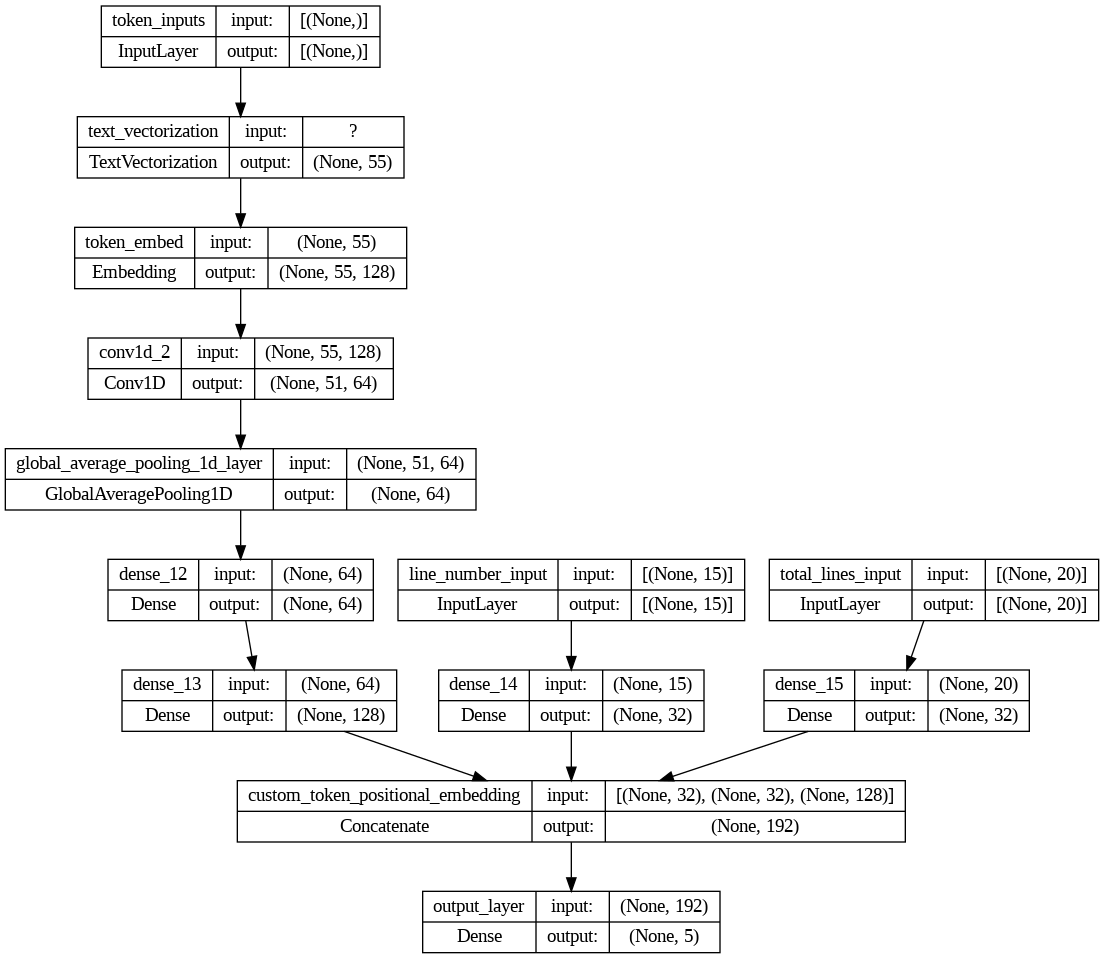

In [110]:
from tensorflow.keras.utils import plot_model
plot_model(model_6, show_shapes=True, to_file='model_6.png')

In [111]:
# Compile the model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create a dataset using tf.data

In [112]:
# Create a training and validation datasets (all 3 kind of inputs)
train_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                           train_total_lines_one_hot,
                                                           train_sentences))
train_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_pos_dataset = tf.data.Dataset.zip((train_token_pos_data, train_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


# Validation dataset
val_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                           val_total_lines_one_hot,
                                                           val_sentences))
val_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_pos_dataset = tf.data.Dataset.zip((val_token_pos_data, val_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# check input shapes
train_token_pos_dataset, val_token_pos_dataset



(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [113]:
# Fit the model
model_6_history = model_6.fit(train_token_pos_dataset,
                              steps_per_epoch=int(.1 * len(train_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_token_pos_dataset,
                              validation_steps=int(.1 * len(val_token_pos_dataset)),
                               callbacks=[create_tensorboard_callback(SAVE_DIR,  'model_6_custom_token_pos_embedding')])

Saving TensorBoard log files to: model_logs/model_6_custom_token_pos_embedding/20240618-171525
Epoch 1/3
562/562 [==============================] - 22s 36ms/step - loss: 1.0093 - accuracy: 0.7744 - val_loss: 0.9436 - val_accuracy: 0.8155
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.8878 - accuracy: 0.8628 - val_loss: 0.9314 - val_accuracy: 0.8162
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.8731 - accuracy: 0.8685 - val_loss: 0.9125 - val_accuracy: 0.8331


In [114]:
model_6_probs = model_6.predict(val_token_pos_dataset, verbose=1)
model_6_probs[:3]

945/945 [==============================] - 2s 2ms/step


array([[0.41361687, 0.06317935, 0.05125976, 0.42678607, 0.04515788],
       [0.3564546 , 0.06563635, 0.07030126, 0.4701596 , 0.0374482 ],
       [0.16193049, 0.04794789, 0.06433805, 0.6788498 , 0.0469338 ]],
      dtype=float32)

In [115]:
model_6_preds = tf.argmax(model_6_probs, axis=1)
model_6_preds[:3]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 3, 3])>

In [116]:
model_6_results = calculate_results(val_labels_encoded, model_6_preds)
model_6_results

{'accuracy': 83.14245994968886,
 'precision': 0.8349991731088906,
 'recall': 0.8314245994968886,
 'f1': 0.8301597470185265}

In [117]:
# Compare results with the the best perfoming model
compare_baseline_to_new_results(model_5_results, model_6_results)

Baseline accuracy: 83.44, New accuracy: 83.14, Difference: -0.30
Baseline precision: 0.83, New precision: 0.83, Difference: 0.00
Baseline recall: 0.83, New recall: 0.83, Difference: -0.00
Baseline f1: 0.83, New f1: 0.83, Difference: -0.00


## Comparing model results


In [118]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline":baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embbeding": model_5_results,
                                  "model_6_custom_token_pos_embedding": model_6_results
                                  })

In [119]:
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,77.373229,0.776698,0.773732,0.772421
model_2_pretrained_token_embedding,71.365683,0.714617,0.713657,0.710607
model_3_custom_char_embedding,65.219118,0.641167,0.652191,0.634028
model_4_hybrid_char_token_embedding,73.662783,0.736569,0.736628,0.733509
model_5_pos_char_token_embbeding,83.443665,0.833186,0.834437,0.833449
model_6_custom_token_pos_embedding,83.142460,0.834999,0.831425,0.830160


In [120]:
# Normalize to the same scale as other scales
all_model_results['accuracy'] = all_model_results['accuracy'] / 100


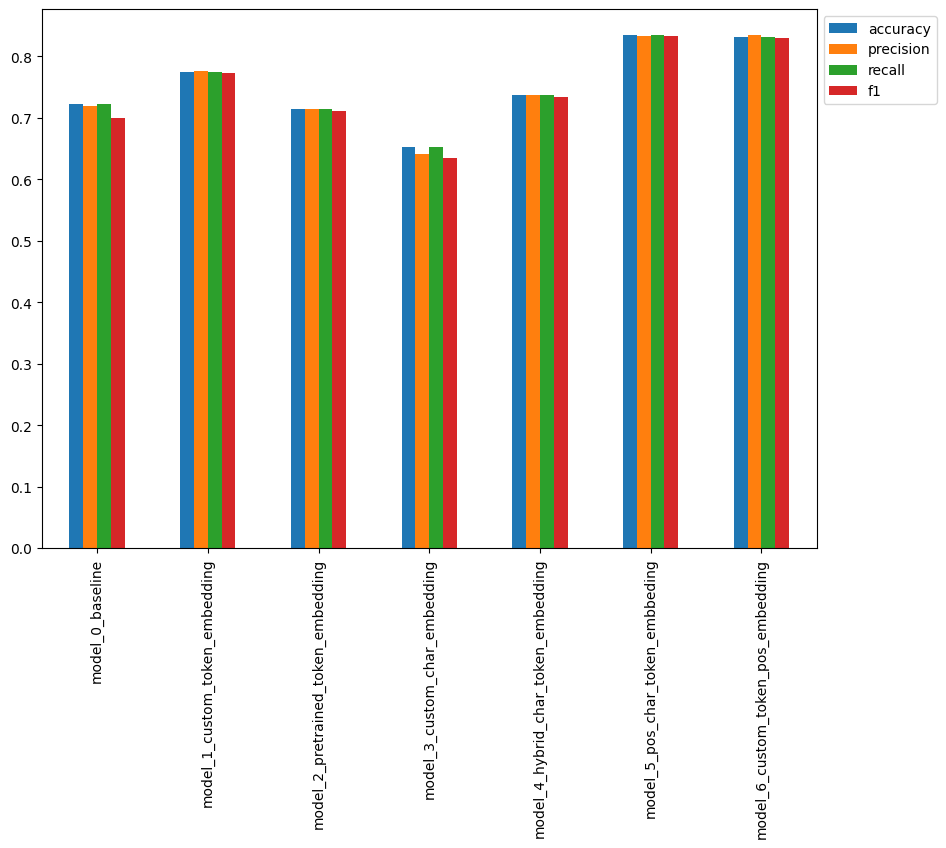

In [121]:
# Plot and compare all model results
all_model_results.plot(kind='bar',  figsize=(10,7)).legend(bbox_to_anchor=(1., 1.))

<Axes: >

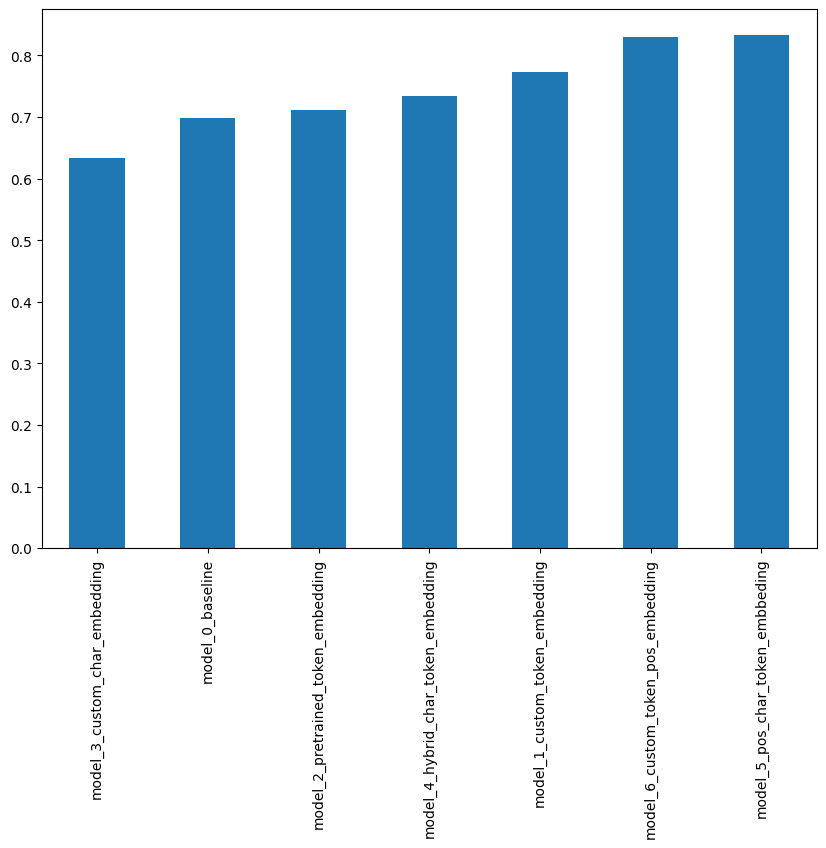

In [122]:
# Sort the results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10,7))

## Save and load model

In [124]:
# Save the best model format
model_6.save('skimlit_model')

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [128]:
model_save_path = '/content/drive/My Drive/models/Medical_paper_abstract.tf'
model_6.save(model_save_path, save_format='tf')

In [129]:
loaded_model = tf.keras.models.load_model(model_save_path)

## Custom Data Prediction

In [131]:
import tensorflow as tf
import re
from spacy.lang.en import English
from collections import defaultdict

abstract = "Fermented foods represent a significant fraction of human diets. Although their impact on health is positively perceived, an objective evaluation is still missing. We have, therefore, reviewed meta-analyses of randomized controlled trials (RCT) investigating the relationship between fermented foods and non-transmissible chronic diseases. Overall, after summarizing 25 prospective studies on dairy products, the association of fermented dairy with cancer was found to be neutral, whereas it was weakly beneficial, though inconsistent, for specific aspects of cardio-metabolic health, in particular stroke and cheese intake. The strongest evidence for a beneficial effect was for yoghurt on risk factors of type 2 diabetes. Although mechanisms explaining this association have not been validated, an increased bioavailability of insulinotropic amino acids and peptides as well as the bacterial biosynthesis of vitamins, in particular vitamin K2, might contribute to this beneficial effect. However, the heterogeneity in the design of the studies and the investigated foods impedes a definitive assessment of these associations. The literature on fermented plants is characterized by a wealth of in vitro data, whose positive results are not corroborated in humans due to the absence of RCTs. Finally, none of the RCTs were specifically designed to address the impact of food fermentation on health. This question should be addressed in future human studies."

def categorize_abstract(abstract):
  nlp = English()
  sentencizer = nlp.create_pipe('sentencizer')
  nlp.add_pipe('sentencizer')
  doc = nlp(abstract)
  original_abstract_lines = [str(sent) for sent in list(doc.sents)]

  abstract_lines = list(map(lambda s: re.sub(r'[0-9]', '@', s), original_abstract_lines))


  total_lines = len(abstract_lines)

  sample_lines = []
  for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i+1
    sample_dict['total_lines'] = total_lines
    sample_lines.append(sample_dict)

  # Create the test datasets
  # get all the total line numbers
  test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
  test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)

  # Get all the totla lies value from sample lines
  test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
  test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

  # Generate the char
  abstract_chars = list(map(lambda text: " ".join(list(text)),abstract_lines ))

  # Predict the Label
  test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                    test_abstract_total_lines_one_hot,
                                                    tf.constant(abstract_lines)
                                                    ))
  #Map the labels
  test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
  test_abstract_preds_classes =  [label_encoder.classes_[i] for i in test_abstract_preds]
  mapped = defaultdict(str)
  for i, line in enumerate(original_abstract_lines):
    print(f'{test_abstract_preds_classes[i]}: {line}')
    mapped[test_abstract_preds_classes[i]] += line
  return mapped

result = categorize_abstract(abstract)


1/1 [==============================] - 0s 211ms/step
BACKGROUND: Fermented foods represent a significant fraction of human diets.
BACKGROUND: Although their impact on health is positively perceived, an objective evaluation is still missing.
BACKGROUND: We have, therefore, reviewed meta-analyses of randomized controlled trials (RCT) investigating the relationship between fermented foods and non-transmissible chronic diseases.
CONCLUSIONS: Overall, after summarizing 25 prospective studies on dairy products, the association of fermented dairy with cancer was found to be neutral, whereas it was weakly beneficial, though inconsistent, for specific aspects of cardio-metabolic health, in particular stroke and cheese intake.
CONCLUSIONS: The strongest evidence for a beneficial effect was for yoghurt on risk factors of type 2 diabetes.
CONCLUSIONS: Although mechanisms explaining this association have not been validated, an increased bioavailability of insulinotropic amino acids and peptides as 

In [132]:
result

defaultdict(str,
            {'BACKGROUND': 'Fermented foods represent a significant fraction of human diets.Although their impact on health is positively perceived, an objective evaluation is still missing.We have, therefore, reviewed meta-analyses of randomized controlled trials (RCT) investigating the relationship between fermented foods and non-transmissible chronic diseases.',
             'CONCLUSIONS': 'Overall, after summarizing 25 prospective studies on dairy products, the association of fermented dairy with cancer was found to be neutral, whereas it was weakly beneficial, though inconsistent, for specific aspects of cardio-metabolic health, in particular stroke and cheese intake.The strongest evidence for a beneficial effect was for yoghurt on risk factors of type 2 diabetes.Although mechanisms explaining this association have not been validated, an increased bioavailability of insulinotropic amino acids and peptides as well as the bacterial biosynthesis of vitamins, in parti